# Data Fundamentals (H)
John H. Williamson / Sebastian Stein -- Session 2023/2024

----

**This submission must be your own work; you will have to make a Declaration of Originality on submission.**

---

## Markov 

## Purpose of this lab
This lab should help you:
* understand probability distributions
* understand Markov chains
* compute likelihoods
* understand simple Bayesian inference
* improve your understanding of candles

## Hints

There is a [hint sheet](markov_hints.ipynb) available for this lab.


### Notes
It is recommended to keep the lecture notes open while doing this lab exercise.

You will need to know the following logarithm identities in this lab:
* $\log(a)+\log(b) = \log(ab)$ 
* $\log(a)-\log(b) = \log(a/b),\  b\neq 0$

$$\newcommand{\vec}[1]{ {\bf #1}} 
\newcommand{\real}{\mathbb{R}}
\DeclareMathOperator*{\argmin}{arg\,min}
\vec{x}\real
$$

In [61]:
# Standard imports
# Make sure you run this cell!
from __future__ import print_function, division
import numpy as np  # NumPy
import scipy.stats 

from jhwutils.checkarr import array_hash, check_hash
import jhwutils.tick as tick
import jhwutils.image_audio as ia

# Set up Matplotlib
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline
print("Everything imported OK")
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)
rng = np.random.default_rng(seed=1000)

Everything imported OK


# Assessed portion: Markov processes
A **stochastic process** or a **random process** is a process that evolves over *time* in an (partially) unpredictable way. The altitude of an aircraft might be modelled as a stochastic process. Although the altitude is controlled to keep it relatively steady during level flight, fluctuations due to turbulence shift the altitude randomly. This randomness can vary; in smooth air the process might be very stable and predictable, but become increasingly random in rough, turbulent air. The position of the aircraft in one moment depends on where it was a moment before, but with some element of randomness.

Unlike the coin tosses, where each toss was *independent* of the one before, **stochastic processes** capture dependence over time.


<img src="imgs/turbulence.png">

*[Original Image by Sergey Kustov [from Wikimedia Commons](https://commons.wikimedia.org/wiki/Category:Featured_pictures_of_aircraft#/media/File:Aeroflot_Airbus_A330_Kustov.jpg) CC-BY-SA 3.0]*

## Markov process
A **Markov process** is a particularly simple kind of **stochastic process**. A **Markov process** is any stochastic process that preserves the **Markov property**:

### Markov property

>The distribution of the state at time $t$ depends **only** on the state at the previous time $t-1$. No other history influences the behaviour of the system. 

Sequential samples from a Markov process are **not** independent; each sample depends on the prior sample (and *only* on the prior sample).  These models are tractable to do computations with, and we can often approximate a stochastic process which might have long-term dependencies with a Markov process with a single step dependency.

### Evolution over time

We consider the process to evolve one time step after the other, so we have a state at time $t=0, t=1, \dots$, represented by a random variable $X_t$, which takes on values $x_1, x_2, x_3, \dots$ at each time step.

The evolution of Markov process is described by a single conditional probability distribution, $P(\vec{X}_t=x_t|x_{t-1})$, the **transition distribution**. It defines what values could occur in one time step, depending on those on the previous time step. Markov processes can have **discrete states** (i.e. their state transitions involve discrete random variables) or **continuous states** (continuous random variables). 

## Discrete time, discrete state: Markov chains

 
### Gilbert model for flickering lights
Consider the problem of modeling the gentle flickering of an LED candle:

<img src="imgs/candle.jpg"> <br><br>*[[Image](https://flickr.com/photos/syntheticaperture/2667040501 "0806B06 - LED Candle Experiment") by [syntheticaperture](https://flickr.com/people/syntheticaperture) shared [CC BY](https://creativecommons.org/licenses/by/2.0/)]*

*[This problem is inspired by the [analysis on cpldcpu's blog](https://cpldcpu.com/2013/12/08/hacking-a-candleflicker-led/), even if the modelling is rather different here]*

The candle light has a simple microcontroller, which updates the LED state every hundredth of a second (100Hz). Choosing a purely random light state for each frame is unsatisfying -- no matter how you choose the random distribution, the result is always "too fast". Because each frame is independent, there is no sense of continuity. The result is unusable.

The solution is to model this as a **stochastic process**; and a powerful way of simplifying that model so it can be made amenable to computational analysis that is to represent the process as a Markov process. This problem is a *discrete* Markov process, because there are two light states: *on* and *off* (we'll assume the light can't be partially on). Discrete Markov processes are known as **Markov chains**.

We can do several things with any Markov chain:
* we can **sample** processes from the chain (e.g. we can simulate the candle behaviour)
* we can **estimate** or **infer** parameters from data (we can work out how the Markov chain was configured by observing)
* we can compute the **likelihood** of observations under an assumed model (e.g. we can see whether a LED candle we observe is likely to be of brand X or brand Y)

### Gilbert model

A very simple Markov chain is the **Gilbert model**, which can be used to model "sticky" processes.  It is often used for simulating "bursty" network traffic, for example. This model has just two states $0$ and $1$ or $A$ and $B$, and the condition probability distribution gives the probability of transitions between these two states.

<img src="imgs/gilbert.png">

The conditional probability can be written as a simple table:

|   | 0    | 1    |
|---|------|------|
| 0 | 1-p1 | p1   |
| 1 | p2   | 1-p2 |

Because the total probability leaving from any given state must be 1.0, we only need two numbers $p_1$ and $p_2$ to fully determine the Markov chain for the Gilbert model.

The model can be seen as a process with a **transition distribution** $p(S_i|S_{i-1})$, where $S_i$ is the random variable representing the state at time $i$ (for a Gilbert model, the state is either 0 or 1). The state at time $i$ depends only on the state at the previous time step.

Writing out every possible combination in full:
$$\begin{align*}P(S_i=0|S_{i-1}=0) &= 1-p_1\\
P(S_i=0|S_{i-1}=1) &= p_2\\
P(S_i=1|S_{i-1}=0) &= p_1\\
P(S_i=1|S_{i-1}=1) &= 1-p_2\\\end{align*}$$

Once we observe a previous state, we know the distribution over the following state.

## Simulation
Let's simulate the Gilbert model first of all. Write a function `gilbert(state, p1, p2, rng)` which will take a previous state (either 0 or 1), two transition probabilities $p_1$ and $p_2$, and a random generator, and return the next state of the Markov chain.

You can see this is a biased coin toss, where the bias depends on the the result of the last coin toss.


In [62]:

def gilbert(state, p1,p2, rng):
    gilbert_matrix = np.array([[1-p1, p1], [p2, 1-p2]])
    gilbert_probs = gilbert_matrix[state]
    state = rng.choice([0, 1], p=gilbert_probs)
    return state

In [63]:
# run the simulation for a number steps
def gilbert_simulate(p1, p2, iters, rng):
    state = 0    
    states = []
    for i in range(iters):
        state = gilbert(state, p1, p2, rng)
        states.append(state)
    return states

In [64]:
rng = np.random.default_rng(2018)

with tick.marks(5):
    test_states = gilbert_simulate(0.5, 0.05, 10000, rng)
    assert(np.abs(np.mean(test_states)-0.9123)<0.01)
    assert(np.abs(np.std(test_states)-0.2828)<0.01)

In [70]:
def candle_gif(states):
    # "visual simulator"
    gif = np.zeros((len(states),32,32,3))
    x = 0
    for i,s in enumerate(states):
        gif[i, :, :, :] = s*0.25
        gif[i, 8:24,8:24, :] = s        
    ia.show_gif(gif, width="64px", duration=0.5)
    
# plot the result
def plot_gilbert(states, p1, p2):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.step(np.arange(len(states)), states)
    ax.set_title("Gilbert model, p1=%.4f, p2=%.4f" % (p1,p2))
    ax.set_xlabel("Steps")
    ax.set_ylabel("State")
    ax.set_frame_on(False)    
    ax.set_yticks([0,1])

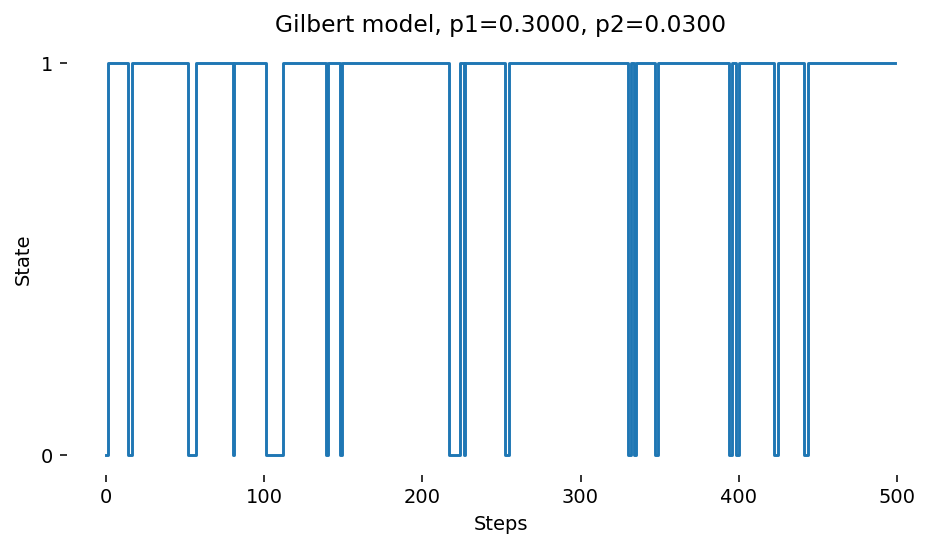

In [71]:
# simulate and plot    
p1, p2 = 0.3, 0.03
rng = np.random.default_rng(2018)
states = gilbert_simulate(p1,p2, iters=500, rng=rng)
plot_gilbert(states, p1, p2)

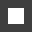

In [72]:
# show a low-fi simulation of this candle
candle_gif(states)

Your result will be random, but should look something like this (long periods of 1, with a few intermittent bursts of 0).

<img src="imgs/gilbert_simulate.png">


### Estimation
We  already saw how to estimate the distribution of a discrete random variable from observed data. 


In this case, where we have a dependency on the previous time step, we just need to compute the empirical distribution of the probability of sequential pairs of states, $P(S_i=s_i, S_{i+1}=s_{i+1})$, as in the letter bigrams in the Unit 8 lecture. From this, we can compute the conditional probabilities directly:

$$P(s_i | s_{i-1}) = \frac{P(s_i, s_{i-1})}{P(s_{i-1})} = \frac{P(s_i, s_{i-1})}{\sum_{s} P(s, s_{i-1})}$$

We can apply this to the sequence we generated, and test that we can recover the parameters that generated the observations.

Write a function to estimate `p1` and `p2` given a set of observed states. You should be able to verify that the results you get back are close to the original simulation parameters for any simulation you run.

You may find it helpful to print out intermediate joint or conditional matrices to help debug this code.


In [73]:
def estimate_gilbert_probabilities(states):
    """
        Parameters:
            states: list of states [0 or 1]
        Returns:
            p1, p2: estimated probabilities of the Gilbert model that generated this sequence
    """
    initial_arr = np.zeros((2, 2))

    for i in range(1, len(states)):
        initial_arr[states[i], states[i - 1]] += 1
        
        
    formula_lower = initial_arr.sum(axis=0, keepdims=True)
    cond_probs = initial_arr / formula_lower

    p1 = cond_probs[1, 0]
    p2 = cond_probs[0, 1]

    return p1, p2

In [74]:
rng = np.random.default_rng(2018)
def report_results(p1, p2):
    print("""
    Estimated transition table
    ------------------------------
          0       1
    0   {p11:.2f}   {p1:.2f}
    1   {p2:.2f}   {p21:.2f}
""".format(p1=p1, p2=p2, p21=1-p2, p11=1-p1))
    
with tick.marks(8):
    for p1, p2 in [[0.2, 0.02], [0.5, 0.5], [0.9, 0.09],
                  [0.05, 0.05], [0.7, 0.1]]:    
        test_states = gilbert_simulate(p1, p2, iters=50000, rng=rng)    
        assert(len(test_states)==50000)            
        est_p1, est_p2 = estimate_gilbert_probabilities(test_states)            
        report_results(est_p1, est_p2)
        assert(np.abs(p1-est_p1)<0.02 and np.abs(p2-est_p2)<0.05)


    Estimated transition table
    ------------------------------
          0       1
    0   0.81   0.19
    1   0.02   0.98


    Estimated transition table
    ------------------------------
          0       1
    0   0.50   0.50
    1   0.50   0.50


    Estimated transition table
    ------------------------------
          0       1
    0   0.10   0.90
    1   0.09   0.91


    Estimated transition table
    ------------------------------
          0       1
    0   0.95   0.05
    1   0.05   0.95


    Estimated transition table
    ------------------------------
          0       1
    0   0.30   0.70
    1   0.10   0.90



We can verify that simulating with the probabilities observed from a simulation results in a quantitatively similar visual effect.

Text(0.5, 1.0, 'Re-simulation from estimated parameters 0.347, 0.036')

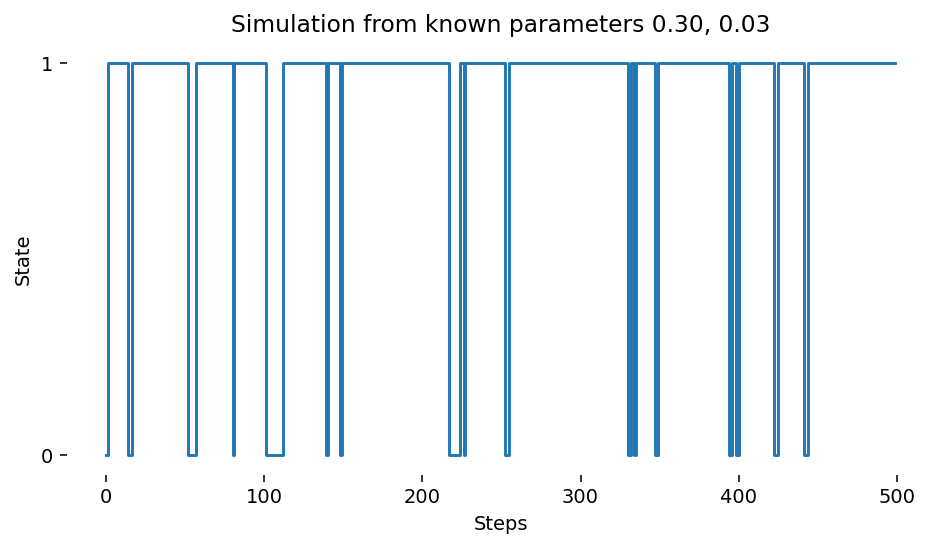

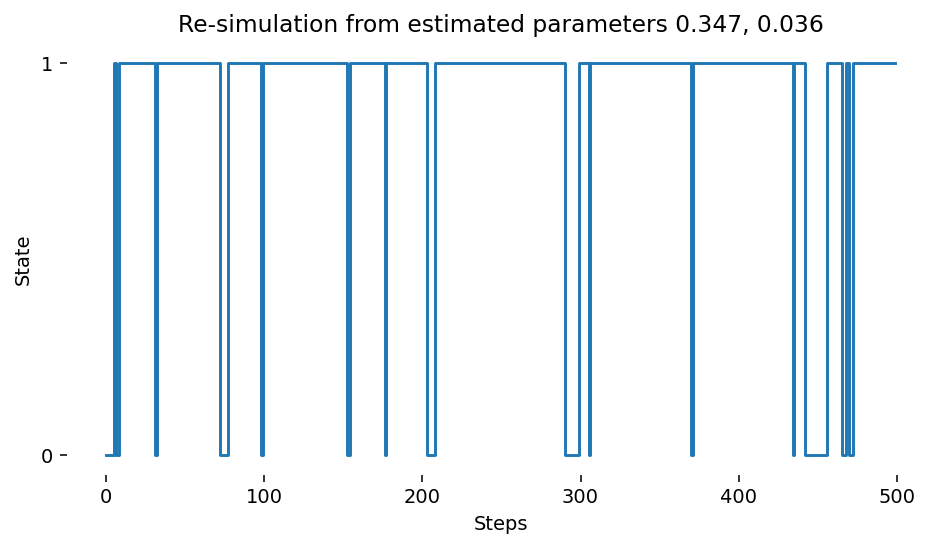

In [75]:
# simulate
p1, p2 = 0.3, 0.03
rng = np.random.default_rng(2018)
states = gilbert_simulate(p1, p2, iters=500, rng=rng)
plot_gilbert(states, p1, p2)

plt.gca().set_title("Simulation from known parameters %.2f, %.2f" % (p1, p2))

est_p1, est_p2 = estimate_gilbert_probabilities(states)

est_states = gilbert_simulate(est_p1, est_p2, iters=500, rng=rng)
plot_gilbert(est_states, est_p1, est_p2)
plt.gca().set_title("Re-simulation from estimated parameters %.3f, %.3f" % (est_p1, est_p2))

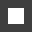

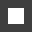

In [76]:
# check the candles look similar enough in simulation
candle_gif(states)
candle_gif(est_states)

### Likelihood
This **looks** qualitatively similar. We can precisely state that quantification using probability.

#### A bit of espionage
Imagine we want to conduct some industrial espionage ("market research") and work out which shops are being supplied with which brand of LED candle. There are candle modules from two companies, *RelaxiLight Inc.*, and *FlickerVision*. We have observations from lab studies of two examples of these candles.

We see a candle on the shelf in a hardware store. We take the candle home and measure the light emitted from it. Is it a *RelaxiLight* or a *FlickerVision*?

## Step 1. Load the data, estimate the parameters
* The data for observations from a known *RelaxiLight Inc.* candle  is in `data/relaxlight.txt`
* The data for observations from a known *FlickerVision* candle is in `data/flickervision.txt`
* The data for five unknown candles (the ones bought in the shops) is in `data/candle_<n>.txt`, for $n=1,2,3,4,5$

All of this data is just a single, long array of 0s and 1s (0 if the candle was off, 1 if it were on).

These are all standard RelaxiLight or FlickerVision candles; except for one, which is a slightly *defective* RelaxiLight or FlickerVision candle.

* Load known data into arrays `relaxilight` and `flickervision`. 
* Load the other five datasets into a 5xN matrix `unknown_candles` (all of the datasets are the same length)

These can be loaded directly with `np.loadtxt()`. Note that you **must** convert the array type to `int32` on loading for `estimate_gilbert_probabilities` to work

In [77]:
# YOUR CODE HERE
relaxilight = np.loadtxt('data/relaxilight.txt', dtype=np.int32)
flickervision = np.loadtxt('data/flickervision.txt', dtype=np.int32)
unknown_candles = np.zeros((5, 500), dtype=np.int32)
for i in range(1, 6):
    filename = f'data/candle_{i}.txt'
    unknown_candles[i-1] = np.loadtxt(filename, dtype=np.int32)

C:\Users\Софія\AppData\Local\Temp\ipykernel_13432\2712782316.py:2: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  relaxilight = np.loadtxt('data/relaxilight.txt', dtype=np.int32)
C:\Users\Софія\AppData\Local\Temp\ipykernel_13432\2712782316.py:3: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` par

In [78]:
print(array_hash(relaxilight))
print(array_hash(flickervision))
print(array_hash(unknown_candles))
with tick.marks(5):
    assert(check_hash(relaxilight, ((5000,), 9858416.2025086209)))
    assert(check_hash(flickervision, ((5000,), 5990789.9841565806)))
    assert(check_hash(unknown_candles, ((5, 500), 2122668.1505949548)))
    assert(relaxilight.dtype==np.int32)
    assert(flickervision.dtype==np.int32)
    assert(unknown_candles.dtype==np.int32)


((5000,), 9858416.20250862)
((5000,), 5990789.984156581)
((5, 500), 2122668.150594955)


* Estimate the parameters for the **known** RelaxiLight Inc. and FlickerVision candles, using the function you defined above.
* Store the parameters in `relaxi_p1`, `relaxi_p2` and `flicker_p1` and `flicker_p2`

In [79]:
# YOUR CODE HERE
relaxi_p1, relaxi_p2 = estimate_gilbert_probabilities(relaxilight)
flicker_p1, flicker_p2 = estimate_gilbert_probabilities(flickervision)

In [80]:
ps = np.array([relaxi_p1, relaxi_p2, flicker_p1, flicker_p2])
print(ps)
with tick.marks(4):
    assert(np.sum(np.abs(ps - [ 0.09533898,  0.02219482,  0.23864959,  0.25392238]))<0.1)

[0.09533898 0.02219482 0.23864959 0.25392238]


### Step 2. Log-likelihood
Write a function that will compute the **log-likelihood** of a sequence given `p1` and `p2`. The easy way to approach this is to create a 2x2 conditional probability table for every possible pair of states, like the one in the first Gilbert example, and index into it as you iterate over the sequence of states.

Note that log-likelihoods will always be negative or zero.
    

In [81]:
def log_likelihood(seq, p1, p2):
    gilbert_matrix = np.array([[1-p1, p1], [p2, 1-p2]])
    log_likelihood_value = 0.0
    
    for i in range(1, len(seq)):
        cond_prob = gilbert_matrix[seq[i-1], seq[i]]
        log_likelihood_value += np.log(cond_prob)
            
        
        
    return log_likelihood_value


print(log_likelihood([0,1,0,1], 0.5, 0.5))
print(log_likelihood([0,1,1,1], 0.5, 0.2))
print(log_likelihood([1,1,1,1], 0.5, 0.2))
        

-2.0794415416798357
-1.1394342831883648
-0.6694306539426291


In [82]:

with tick.marks(6):
    assert(np.abs(log_likelihood([0,1,0,1], 0.5, 0.5) - -2.07944154168)<0.1)
    assert(np.abs(log_likelihood([0,1,1,1], 0.5, 0.2) - -1.13943428319)<0.1)
    assert(np.abs(log_likelihood([1,1,1,1], 0.5, 0.2) - -0.669430653943)<0.1)


### Step 3. Ratio test
25% of all candles on the market are RelaxiLight, and 75% of all candles are FlickerVision (flickery candles are cheap to produce!).

* Compute  the log probability ratio $$\log \left[ \frac{P(A_1|B)}{P(A_2|B)} \right]$$ that each of the five candles is to be a FlickerVision ($A_1$)over a RelaxiLight ($A_2$), storing the result in an array `candle_log_probs`. The log probability ratio includes both the likelihood and the prior.

* Create an array `is_flickervision` that has one entry for each unknown candle, 0 if the candle is most likely to be RelaxiLight, and 1 if the candle is most likely to be FlickerVision.



In [83]:
# YOUR CODE HERE
relaxilight_prob = 0.25
flickerversion_prob = 0.75

candle_log_probs = np.zeros(5)
for i in range(5):

    log_likelihood_r = log_likelihood(unknown_candles[i], relaxi_p1, relaxi_p2)
    log_likelihood_f = log_likelihood(unknown_candles[i], flicker_p1, flicker_p2)
    
    log_prob_ratio = (log_likelihood_f + np.log(flickerversion_prior)) - (log_likelihood_r + np.log(relaxilight_prior))

    candle_log_probs[i] = log_prob_ratio
    
    


In [84]:
# YOUR CODE HERE
is_flickervision = candle_log_probs > 0

In [85]:
print(candle_log_probs)
with tick.marks(5):
    assert(np.sum(np.abs(candle_log_probs-[-91,119,-74,-97,140]))<5.0)

[-91.71633843 119.87678557 -74.07528499 -97.79321901 140.20061013]


In [86]:
print(is_flickervision)
print(array_hash(is_flickervision))
with tick.marks(4):
    assert(check_hash(is_flickervision, ((5,), 8.8898979485566354)))

[False  True False False  True]
((5,), 8.889897948556635)



* Which candle is most likely to be the defective one?
[no marks for this; skip it if you can't work out how to answer this question!]
    

In [88]:
# YOUR CODE HERE
most_likely_defective = np.argmax(candle_log_probs)

-----

# Submission instructions

## Before submission

* Make sure you fill in any place that says `YOUR CODE HERE` or `"YOUR ANSWER HERE"`.
* SAVE THE NOTEBOOK
* DO NOT RENAME THE NOTEBOOK OR IT WILL NOT BE MARKED.

<div class="alert alert-block alert-danger">
    
### Formatting the submission
* **WARNING**: If you do not submit the correct file, you will not get any marks.
* Submit this file **only** on Moodle. It will be named `<xxx>.ipynb`.

</div>


## Penalties (only for assessed labs)
<font color="red">
    
**Malformatted submissions**
</font>
These assignments are processed with an automatic tool; failure to follow instructions *precisely* will lead to you automatically losing two bands in grade regardless of whether the work is correct (not to mention a long delay in getting your work back). **If you submit a file without your work in it, it will be marked and you will get 0 marks.**

<font color="red">**Late submission**</font>
Be aware that there is a two band penalty for every *day* of late submission, starting the moment of the deadline.

<font color="red">
    
**Plagiarism**
</font> Plagiarism will be subject to the Plagiarism Policy. The penalties are severe.